# UHECR propagation analysis


This notebook illustrates how to perform and analyse simulations of UHECR propagation.
For now, only the Lorentz-invariant case is analysed, since there is no software available for LIV studies.

In [1]:
using Corpuscles
using CSV
using DataFrames
using CairoMakie
using StatsBase

In [2]:
"""
Reads a simulation file and returns a DataFrame with the data.
"""
function readSimulation(filename)	
	columns = ["D", "ID", "E", "ID0", "E0", "W"]
	data = CSV.File(filename; header = columns, comment = "#") |> DataFrame
	return data
end



readSimulation

Now we proceed with the postprocessing of the simulation. 
We simulated events following a distribution
\begin{equation}
	\dfrac{\text{d}N}{\text{d}E_0} \propto E_0^{-1}	\,.
\end{equation}

Suppose we actually wanted to have events distributed according to
\begin{equation}
	\dfrac{\text{d}N}{\text{d}E_0} \propto E_0^{-\alpha} \exp\left( - \dfrac{E}{Z R_{\text{max}}}\right)	\,.
\end{equation}

The reweighting procedure for this change is implemented in the function below

In [ ]:
"""
Given a dataframe with the simulation, this function computes the desired weights.
These weights are saved in the dataframe as a new column with a name of choice (here `W1`).
The simulation is assumed to have a spectrum E^(-α0), with α0=1 in this case.

# Input
. `data`: dataframe containing the simulations \\
. `α`: desired spectral index \\
. `Rmax`: spectrum cuts off above Z Rmax, where Z is the atomic number of the nucleus \\
. `columnName`: name of the column to be created; defaults to 'W1' \\
. `α0`: injection spectrum used in the simulation (default to α0 = 1) \\
"""
function reweightSimulation!(data, α, Rmax; columnName = "W1", α0 = 1.)
	# define the function for reweighting the spectrum
	weightSpectrum(E, Z) = E ^ (α0 - α) * exp(- E / (Z * Rmax))

	# other functions can be defined here, e.g. for the distance weight
	# weightDistance = ....


	data[!, columnName] = @. weightSpectrum(data.E0, Z(PDGID(data.ID0)))
end

reweightSimulation!

In [4]:
filename_p = "simulations/sim1D-A_01_Z_01-SR.txt"
data_p = readSimulation(filename_p)

reweightSimulation!(data_p, 2.0, 1e20; columnName = "W1")
reweightSimulation!(data_p, 2.0, 3e19; columnName = "W2")
reweightSimulation!(data_p, 1.5, 1e20; columnName = "W3")
reweightSimulation!(data_p, 1.5, 3e19; columnName = "W4")
;

In [5]:
nBinsE = 30
binEmin, binEmax = 1e18, 1e21
binEdgesE = 10 .^ range(log10(binEmin), log10(binEmax), length = nBinsE + 1)
binCentresE = 10 .^ [(log10(binEdgesE[i]) + log10(binEdgesE[i + 1])) / 2. for i in 1 : nBinsE]

spec1 = fit(Histogram, data_p.E, weights(data_p.W1), binEdgesE)
spec2 = fit(Histogram, data_p.E, weights(data_p.W2), binEdgesE)
spec3 = fit(Histogram, data_p.E, weights(data_p.W3), binEdgesE)
spec4 = fit(Histogram, data_p.E, weights(data_p.W4), binEdgesE);


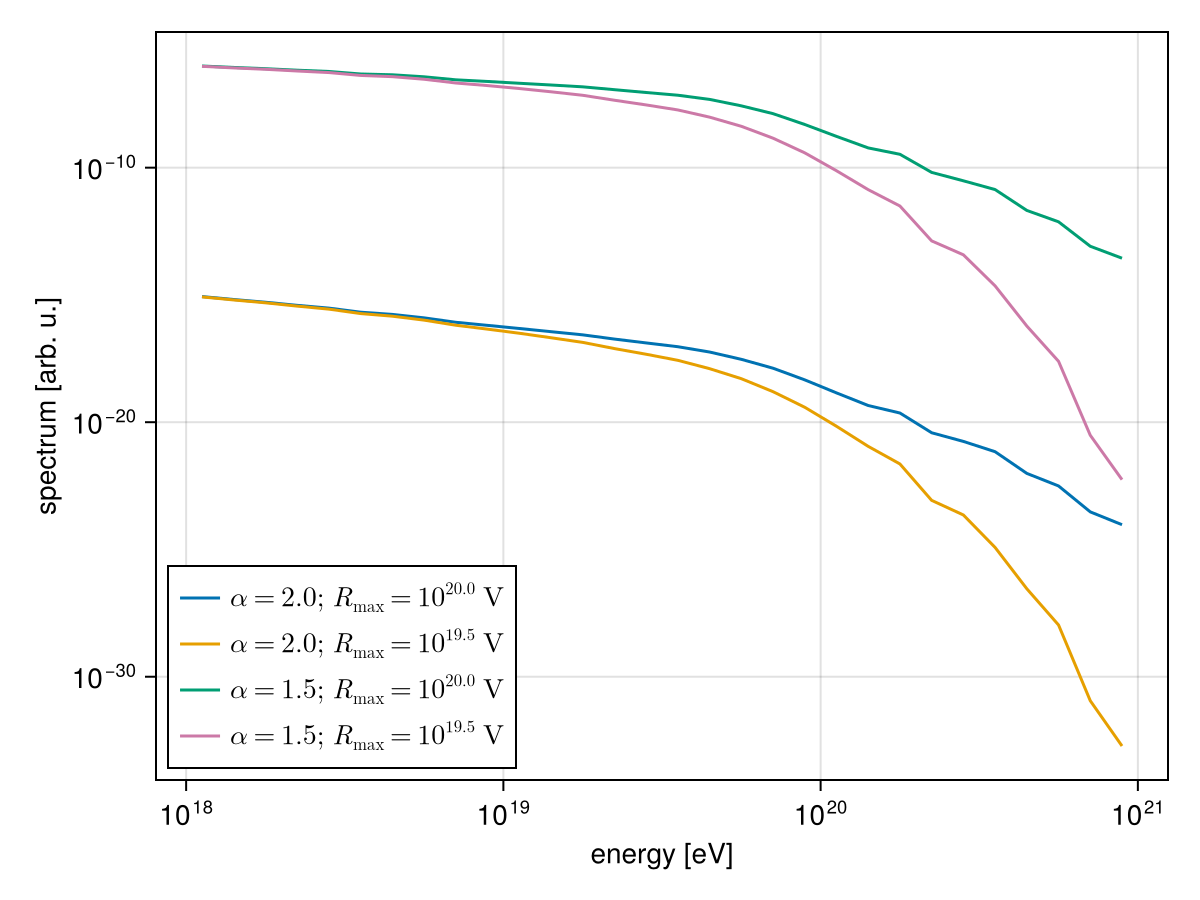

In [6]:
fig = Figure()
ax = Axis(fig[1, 1]; xlabel = "energy [eV]", ylabel = "spectrum [arb. u.]", xscale = log10, yscale = log10)
lines!(ax, binCentresE, spec1.weights; label = L"\alpha = 2.0; \; R_{\mathrm{max}} = 10^{20.0} \; \text{V}")
lines!(ax, binCentresE, spec2.weights; label = L"\alpha = 2.0; \; R_{\mathrm{max}} = 10^{19.5} \; \text{V}")
lines!(ax, binCentresE, spec3.weights; label = L"\alpha = 1.5; \; R_{\mathrm{max}} = 10^{20.0} \; \text{V}")
lines!(ax, binCentresE, spec4.weights; label = L"\alpha = 1.5; \; R_{\mathrm{max}} = 10^{19.5} \; \text{V}")
axislegend(ax; position = :lb)

fig
